In [1]:
import requests
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

## Data Collection

In [120]:
def fetch_all_vacancies(text: str):
    url = "https://api.hh.ru/vacancies"
    params = {
        "text": text,             
        "area": 40,                 
        "per_page": 100,        
        'industry': 7     
    }
    all_vacancies = []
    page = 0 

    while True:
        params["page"] = page
        response = requests.get(url, params=params)
        
        if response.status_code != 200:
            print(f"Ошибка: {response.status_code}, {response.text}")
            break

        data = response.json()
        items = data.get("items", [])
        all_vacancies.extend(items)

        print(f"Обработана страница {page + 1}, найдено вакансий: {len(items)}")
        if page >= data.get("pages", 0) - 1:
            break
        page += 1 

    print(f"Всего собрано вакансий: {len(all_vacancies)}")
    return all_vacancies

In [121]:
data_DA = fetch_all_vacancies("Data analyst")

Обработана страница 1, найдено вакансий: 43
Всего собрано вакансий: 43


In [122]:
data_QA = fetch_all_vacancies("QA Engineer")

Обработана страница 1, найдено вакансий: 91
Всего собрано вакансий: 91


In [123]:
data_SA = fetch_all_vacancies("System analyst")

Обработана страница 1, найдено вакансий: 49
Всего собрано вакансий: 49


In [124]:
data_PM = fetch_all_vacancies("Product Manager")

Обработана страница 1, найдено вакансий: 50
Всего собрано вакансий: 50


In [125]:
data_Back = fetch_all_vacancies('Backend Developer')

Обработана страница 1, найдено вакансий: 100
Обработана страница 2, найдено вакансий: 25
Всего собрано вакансий: 125


In [126]:
data_IOS = fetch_all_vacancies("IOS Developer")

Обработана страница 1, найдено вакансий: 49
Всего собрано вакансий: 49


In [127]:
data_Android = fetch_all_vacancies('Android Developer')

Обработана страница 1, найдено вакансий: 52
Всего собрано вакансий: 52


In [128]:
data_Front = fetch_all_vacancies("Frontend Developer")

Обработана страница 1, найдено вакансий: 100
Обработана страница 2, найдено вакансий: 2
Всего собрано вакансий: 102


In [129]:
data_Devops = fetch_all_vacancies("DevOps")

Обработана страница 1, найдено вакансий: 74
Всего собрано вакансий: 74


In [130]:
data_Security = fetch_all_vacancies('Security engineer')

Обработана страница 1, найдено вакансий: 78
Всего собрано вакансий: 78


In [131]:

def process_vacancies(data):
    vacancies = []
    for item in data:
        salary = item.get("salary")
        vacancies.append({
            "name": item.get("name"),
            "area_name": item.get("area", {}).get("name"),
            "salary_from": salary.get("from") if salary else None,
            "salary_to": salary.get("to") if salary else None,
            "salary_currency": salary.get("currency") if salary else None,
            "published_at": item.get("published_at"),
            "employer_name": item.get("employer", {}).get("name"),
            "requirement": item.get("snippet", {}).get("requirement"),
            "schedule_id": item.get("schedule", {}).get("id"),
            "working_hours_id": item.get("working_hours", [{}])[0].get("id") if item.get("working_hours") else None,
            "work_schedule_by_days": item.get("work_schedule_by_days", [{}])[0].get("name") if item.get("work_schedule_by_days") else None,
            "professional_roles": ", ".join(role.get("name", "") for role in item.get("professional_roles", [])),
            "experience_name": item.get("experience", {}).get("name"),
            "employment_id": item.get("employment", {}).get("id"),
        })
    return pd.DataFrame(vacancies)

In [132]:
df_DA = process_vacancies(data_DA)
df_SA = process_vacancies(data_SA)
df_Backend = process_vacancies(data_Back)
df_QA = process_vacancies(data_QA)
df_IOS = process_vacancies(data_IOS)
df_Android = process_vacancies(data_Android)
df_Security = process_vacancies(data_Security)
df_Front = process_vacancies(data_Front)
df_DevOps = process_vacancies(data_Devops)
df_PM = process_vacancies(data_PM)

In [10]:
df_full = [df_Front,df_DevOps,df_Android,df_Backend,df_DA,df_IOS,df_PM,df_SA,df_Security,df_QA]
df_full = pd.concat(df_full,ignore_index=True)

NameError: name 'df_Front' is not defined

In [143]:
len(df_full)

713

In [144]:
df_full.to_csv("data/all_vacancies.csv", index=False)
df_Android.to_csv('data/android_vacancies.csv',index=False)
df_Backend.to_csv('data/backend_vacancies.csv', index=False)
df_PM.to_csv('data/pm_vacancies.csv', index=False)
df_DA.to_csv('data/da_vacancies.csv', index=False)
df_QA.to_csv('data/qa_vacancies.csv', index=False)
df_IOS.to_csv('data/ios_vacancies.csv', index=False)
df_DevOps.to_csv('data/devops_vacancies.csv', index=False)
df_Security.to_csv('data/security_vacancies.csv', index=False)
df_Front.to_csv('data/frontend_vacancies.csv', index=False)
df_SA.to_csv("data/sa_vacancies.csv", index=False)

## Data Analysis

In [2]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
import string
from sklearn.feature_extraction.text import CountVectorizer


In [3]:
nltk.download('stopwords')
stop_words = set(stopwords.words('russian') + stopwords.words('english'))
custom_sw = ['опыт','работы',"experience",'знание','понимание','знания','умение','knowledge',
             'принципов','working','highlighttextdatahighlighttext','ability','–','—',
             'highlighttext','лет','years','навыки','работать','understanding','инструментами']
stop_words.update(custom_sw)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dias\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def get_req_freqeuncy(data: list):
    text = " ".join(data)
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    words = [word for word in text.split() if word not in stop_words]

    return Counter(words)

def get_req_phrases(data:list):
    vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words=list(stop_words))
    X = vectorizer.fit_transform(data)
    phrases = vectorizer.get_feature_names_out()
    counts = X.toarray().sum(axis=0)
    return Counter(dict(zip(phrases, counts)))



In [5]:
df_Android = pd.read_csv('data/android_vacancies.csv')
df_Backend = pd.read_csv('data/backend_vacancies.csv')
df_PM = pd.read_csv('data/pm_vacancies.csv')
df_DA = pd.read_csv('data/da_vacancies.csv')
df_QA = pd.read_csv('data/qa_vacancies.csv')
df_IOS = pd.read_csv('data/ios_vacancies.csv')
df_DevOps = pd.read_csv('data/devops_vacancies.csv')
df_Security = pd.read_csv('data/security_vacancies.csv')
df_Front = pd.read_csv('data/frontend_vacancies.csv')
df_SA = pd.read_csv("data/sa_vacancies.csv")

In [21]:
req_DA = get_req_freqeuncy(df_DA['requirement'].to_list())
phrases_DA = get_req_phrases(df_DA['requirement'].to_list())

req_Android = get_req_freqeuncy(df_Android['requirement'].to_list())
phrases_Android = get_req_phrases(df_Android['requirement'].to_list())

req_Backend = get_req_freqeuncy(df_Backend['requirement'].to_list())
phrases_Backend = get_req_phrases(df_Backend['requirement'].to_list())

req_PM = get_req_freqeuncy(df_PM['requirement'].to_list())
phrases_PM = get_req_phrases(df_PM['requirement'].to_list())

req_QA = get_req_freqeuncy(df_QA['requirement'].to_list())
phrases_QA = get_req_phrases(df_QA['requirement'].to_list())

req_IOS = get_req_freqeuncy(df_IOS['requirement'].to_list())
phrases_IOS = get_req_phrases(df_IOS['requirement'].to_list())

req_DevOps = get_req_freqeuncy(df_DevOps['requirement'].to_list())
phrases_DevOps = get_req_phrases(df_DevOps['requirement'].to_list())

req_Security = get_req_freqeuncy(df_Security['requirement'].to_list())
phrases_Security = get_req_phrases(df_Security['requirement'].to_list())

req_Front = get_req_freqeuncy(df_Front['requirement'].to_list())
phrases_Front = get_req_phrases(df_Front['requirement'].to_list())

req_SA = get_req_freqeuncy(df_SA['requirement'].astype(str).to_list())
phrases_SA = get_req_phrases(df_SA['requirement'].astype(str).to_list())

In [29]:
print(f"Самые часто встречающиеся слова в требованиях Дата Аналитики:\n{req_DA.most_common(15)}",end='\n\n')
print(f"Самые часто встречающиеся фразы в требованиях Дата Аналитики: \n{phrases_DA.most_common(15)}")


Самые часто встречающиеся слова в требованиях Дата Аналитики:
[('данных', 8), ('2', 8), ('highlighttextаналитикиhighlighttext', 4), ('python', 4), ('science', 4), ('integration', 4), ('sql', 4), ('архитектуры', 4), ('dbt', 3), ('системами', 3), ('analytics', 3), ('excel', 3), ('power', 3), ('highlighttextanalysthighlighttext', 3), ('big', 3)]

Самые часто встречающиеся фразы в требованиях Дата Аналитики: 
[('data integration', np.int64(4)), ('big data', np.int64(3)), ('data science', np.int64(3)), ('data visualization', np.int64(3)), ('advanced excel', np.int64(2)), ('advanced excel google', np.int64(2)), ('airflow jupyter', np.int64(2)), ('airflow jupyter notebook', np.int64(2)), ('analytics data', np.int64(2)), ('analytics data modelling', np.int64(2)), ('arrays pivots', np.int64(2)), ('arrays pivots data', np.int64(2)), ('banking data', np.int64(2)), ('banking data data', np.int64(2)), ('build tool', np.int64(2))]


In [30]:
print(f"Самые часто встречающиеся слова в требованиях Андроид Разработки:\n{req_Android.most_common(15)}",end='\n\n')
print(f"Самые часто встречающиеся фразы в требованиях Андроид Разработки: \n{phrases_Android.most_common(15)}")

Самые часто встречающиеся слова в требованиях Андроид Разработки:
[('highlighttextразработкиhighlighttext', 35), ('highlighttextandroidhighlighttext', 27), ('ios', 11), ('проектов', 11), ('менее', 10), ('приложений', 8), ('unity', 8), ('kotlin', 7), ('коммерческих', 7), ('highlighttextразработкеhighlighttext', 7), ('3', 6), ('года', 6), ('мобильных', 6), ('studio', 5), ('1', 5)]

Самые часто встречающиеся фразы в требованиях Андроид Разработки: 
[('ios android', np.int64(8)), ('коммерческих проектов', np.int64(6)), ('разработки коммерческих', np.int64(6)), ('разработки коммерческих проектов', np.int64(6)), ('android studio', np.int64(5)), ('выпущенных production', np.int64(5)), ('коммерческих проектов unity', np.int64(5)), ('проектов unity', np.int64(5)), ('проектов выпущенных', np.int64(5)), ('проектов выпущенных production', np.int64(5)), ('разработки android', np.int64(5)), ('разработки проектов', np.int64(5)), ('разработки проектов выпущенных', np.int64(5)), ('android ios', np.int6

In [31]:
print(f"Самые часто встречающиеся слова в требованиях Backend Developer:\n{req_Backend.most_common(15)}",end='\n\n')
print(f"Самые часто встречающиеся фразы в требованиях Backend Developer: \n{phrases_Backend.most_common(15)}")

Самые часто встречающиеся слова в требованиях Backend Developer:
[('highlighttextразработкиhighlighttext', 42), ('highlighttextdevelopmenthighlighttext', 23), ('spring', 20), ('java', 19), ('3', 17), ('php', 17), ('highlighttextbackendhighlighttext', 16), ('api', 16), ('python', 11), ('5', 11), ('framework', 11), ('rest', 10), ('highlighttextразработкеhighlighttext', 10), ('frontend', 9), ('javascript', 9)]

Самые часто встречающиеся фразы в требованиях Backend Developer: 
[('spring boot', np.int64(9)), ('node js', np.int64(6)), ('rest api', np.int64(6)), ('software development', np.int64(5)), ('back end', np.int64(4)), ('backend development', np.int64(4)), ('java spring', np.int64(4)), ('java spring boot', np.int64(4)), ('php mysql', np.int64(4)), ('spring framework', np.int64(4)), ('vue js', np.int64(4)), ('коммерческой разработки', np.int64(4)), ('api backend', np.int64(3)), ('best practices', np.int64(3)), ('core spring', np.int64(3))]


In [32]:
print(f"Самые часто встречающиеся слова в требованиях DevOps:\n{req_DevOps.most_common(15)}",end='\n\n')
print(f"Самые часто встречающиеся фразы в требованиях DevOps: \n{phrases_DevOps.most_common(15)}")

Самые часто встречающиеся слова в требованиях DevOps:
[('highlighttextdevopshighlighttext', 35), ('docker', 13), ('cicd', 10), ('kubernetes', 10), ('linux', 10), ('java', 8), ('2', 7), ('spring', 7), ('aws', 6), ('плюсом', 6), ('db', 6), ('python', 5), ('data', 5), ('gitlab', 5), ('данных', 5)]

Самые часто встречающиеся фразы в требованиях DevOps: 
[('ci cd', np.int64(11)), ('docker kubernetes', np.int64(5)), ('devops methods', np.int64(3)), ('machine learning', np.int64(3)), ('spring boot', np.int64(3)), ('области devops', np.int64(3)), ('advanced expertise', np.int64(2)), ('advanced expertise machine', np.int64(2)), ('agile devops', np.int64(2)), ('ansible terraform', np.int64(2)), ('arango db', np.int64(2)), ('arango db devops', np.int64(2)), ('bash another', np.int64(2)), ('cassandra db', np.int64(2)), ('cassandra db arango', np.int64(2))]


In [33]:
print(f"Самые часто встречающиеся слова в требованиях Frontend:\n{req_Front.most_common(15)}",end='\n\n')
print(f"Самые часто встречающиеся фразы в требованиях Frontend: \n{phrases_Front.most_common(15)}")

Самые часто встречающиеся слова в требованиях Frontend:
[('highlighttextразработкиhighlighttext', 33), ('highlighttextfrontendhighlighttext', 20), ('highlighttextdevelopmenthighlighttext', 20), ('react', 19), ('javascript', 15), ('angular', 11), ('spring', 11), ('highlighttextfronthighlighttexthighlighttextendhighlighttext', 9), ('api', 9), ('git', 9), ('3', 9), ('typescript', 9), ('5', 9), ('менее', 8), ('html', 8)]

Самые часто встречающиеся фразы в требованиях Frontend: 
[('front end', np.int64(9)), ('frontend development', np.int64(8)), ('javascript typescript', np.int64(8)), ('ci cd', np.int64(6)), ('angular react', np.int64(5)), ('html css', np.int64(5)), ('node js', np.int64(5)), ('spring boot', np.int64(5)), ('контроля версий', np.int64(5)), ('development html', np.int64(4)), ('development html javascript', np.int64(4)), ('development react', np.int64(4)), ('frontend development html', np.int64(4)), ('html javascript', np.int64(4)), ('html javascript typescript', np.int64(4))]


In [34]:
print(f"Самые часто встречающиеся слова в требованиях IOS Developer:\n{req_IOS.most_common(15)}",end='\n\n')
print(f"Самые часто встречающиеся фразы в требованиях IOS Developer: \n{phrases_IOS.most_common(15)}")

Самые часто встречающиеся слова в требованиях IOS Developer:
[('highlighttextразработкиhighlighttext', 34), ('highlighttextioshighlighttext', 22), ('проектов', 12), ('android', 11), ('приложений', 8), ('highlighttextdevelopmenthighlighttext', 8), ('highlighttextразработкеhighlighttext', 7), ('3', 7), ('менее', 7), ('коммерческих', 6), ('мобильных', 5), ('уверенное', 5), ('commercial', 5), ('api', 5), ('unity', 5)]

Самые часто встречающиеся фразы в требованиях IOS Developer: 
[('ios android', np.int64(8)), ('коммерческих проектов', np.int64(6)), ('разработки коммерческих', np.int64(6)), ('разработки коммерческих проектов', np.int64(6)), ('android ios', np.int64(5)), ('выпущенных production', np.int64(5)), ('коммерческих проектов unity', np.int64(5)), ('проектов unity', np.int64(5)), ('проектов выпущенных', np.int64(5)), ('проектов выпущенных production', np.int64(5)), ('разработки проектов', np.int64(5)), ('разработки проектов выпущенных', np.int64(5)), ('unity менее', np.int64(4)), ('

In [35]:
print(f"Самые часто встречающиеся слова в требованиях Product Manager:\n{req_PM.most_common(15)}",end='\n\n')
print(f"Самые часто встречающиеся фразы в требованиях Product Manager: \n{phrases_PM.most_common(15)}")

Самые часто встречающиеся слова в требованиях Product Manager:
[('highlighttextproducthighlighttext', 10), ('образование', 9), ('высшее', 8), ('highlighttextmanagerhighlighttext', 6), ('сфере', 6), ('менее', 6), ('3', 6), ('2', 5), ('техническое', 5), ('позиции', 4), ('внедрения', 4), ('research', 4), ('owner', 3), ('аналогичной', 3), ('качестве', 3)]

Самые часто встречающиеся фразы в требованиях Product Manager: 
[('product manager', np.int64(5)), ('высшее образование', np.int64(4)), ('product owner', np.int64(3)), ('aso ftue', np.int64(2)), ('aso ftue good', np.int64(2)), ('audience research', np.int64(2)), ('custdev глубинные', np.int64(2)), ('custdev глубинные решенческие', np.int64(2)), ('ftue good', np.int64(2)), ('ftue good market', np.int64(2)), ('funnel ua', np.int64(2)), ('funnel ua aso', np.int64(2)), ('good market', np.int64(2)), ('good market audience', np.int64(2)), ('grasp mobile', np.int64(2))]


In [36]:
print(f"Самые часто встречающиеся слова в требованиях QA Engineer:\n{req_QA.most_common(15)}",end='\n\n')
print(f"Самые часто встречающиеся фразы в требованиях QA Engineer: \n{phrases_QA.most_common(15)}")

Самые часто встречающиеся слова в требованиях QA Engineer:
[('тестирования', 32), ('разработки', 20), ('java', 12), ('sql', 12), ('2', 9), ('api', 9), ('3', 8), ('qa', 8), ('тестировании', 8), ('процессов', 8), ('высшее', 7), ('образование', 7), ('систем', 7), ('highlighttextqahighlighttext', 7), ('android', 6)]

Самые часто встречающиеся фразы в требованиях QA Engineer: 
[('процессов разработки', np.int64(6)), ('баг трекинговых', np.int64(5)), ('баг трекинговых систем', np.int64(5)), ('веб приложений', np.int64(5)), ('высшее образование', np.int64(5)), ('тест дизайна', np.int64(5)), ('трекинговых систем', np.int64(5)), ('api тестировании', np.int64(4)), ('автоматизации тестирования', np.int64(4)), ('жизненного цикла', np.int64(4)), ('команде тестировании', np.int64(4)), ('команде тестировании api', np.int64(4)), ('приложений баг', np.int64(4)), ('приложений баг трекинговых', np.int64(4)), ('тестировании api', np.int64(4))]


In [37]:
print(f"Самые часто встречающиеся слова в требованиях System Analytics:\n{req_SA.most_common(15)}",end='\n\n')
print(f"Самые часто встречающиеся фразы в требованиях System Analytics: \n{phrases_SA.most_common(15)}")

Самые часто встречающиеся слова в требованиях System Analytics:
[('highlighttextаналитикаhighlighttext', 9), ('года', 7), ('образование', 7), ('highlighttextсистемнымhighlighttext', 6), ('highlighttextаналитикомhighlighttext', 6), ('sql', 6), ('highlighttextсистемногоhighlighttext', 6), ('высшее', 6), ('разработки', 6), ('менее', 5), ('роли', 5), ('3', 5), ('3х', 5), ('1', 4), ('проектах', 4)]

Самые часто встречающиеся фразы в требованиях System Analytics: 
[('системного аналитика', np.int64(9)), ('системным аналитиком', np.int64(6)), ('бизнес системного', np.int64(4)), ('бизнес системного аналитика', np.int64(4)), ('высшее образование', np.int64(4)), ('system analyst', np.int64(3)), ('бизнес системных', np.int64(3)), ('бизнес системных аналитиков', np.int64(3)), ('жизненного цикла', np.int64(3)), ('системных аналитиков', np.int64(3)), ('data warehousing', np.int64(2)), ('figma фасилитации', np.int64(2)), ('figma фасилитации воркшопов', np.int64(2)), ('full stack', np.int64(2)), ('ful

In [38]:
print(f"Самые часто встречающиеся слова в требованиях Security engineer:\n{req_Security.most_common(15)}",end='\n\n')
print(f"Самые часто встречающиеся фразы в требованиях Security engineer: \n{phrases_Security.most_common(15)}")

Самые часто встречающиеся слова в требованиях Security engineer:
[('highlighttextбезопасностиhighlighttext', 26), ('образование', 12), ('разработки', 10), ('основ', 9), ('информационной', 9), ('highlighttextsecurityhighlighttext', 9), ('области', 8), ('highlighttextengineeringhighlighttext', 8), ('систем', 8), ('высшее', 8), ('менее', 8), ('3', 7), ('техническое', 7), ('spring', 7), ('ms', 6)]

Самые часто встречающиеся фразы в требованиях Security engineer: 
[('информационной безопасности', np.int64(9)), ('высшее техническое', np.int64(6)), ('техническое образование', np.int64(6)), ('высшее техническое образование', np.int64(5)), ('сетевой безопасности', np.int64(4)), ('ms office', np.int64(3)), ('ms office ms', np.int64(3)), ('ms visio', np.int64(3)), ('office ms', np.int64(3)), ('office ms visio', np.int64(3)), ('software engineering', np.int64(3)), ('безопасности приветствуется', np.int64(3)), ('безопасности сетевых', np.int64(3)), ('веб приложений', np.int64(3)), ('основ информаци

In [39]:
df = pd.read_csv('data/all_vacancies.csv')

In [40]:
numeric_summary = df.describe(include=[np.number])

numeric_summary

,salary_from,salary_to
count,1.820000e+02,1.410000e+02
mean,5.151522e+05,6.936851e+05
std,3.562598e+05,4.844285e+05
min,1.000000e+03,2.000000e+02
25%,3.000000e+05,3.000000e+05
50%,4.500000e+05,6.000000e+05
75%,7.000000e+05,1.000000e+06
max,1.500000e+06,2.000000e+06


salary_from: Mean is 515,152 KZT, with a wide range (1,000 to 1,500,000 KZT).
salary_to: Mean is 693,685 KZT, ranging from 200 to 2,000,000 KZT.
Significant missing values: 531 in salary_from and 572 in salary_to.

In [26]:
missing_values = df.isnull().sum()

missing_values

name                       0
area_name                  0
salary_from              531
salary_to                572
salary_currency          504
published_at               0
employer_name              0
requirement                1
schedule_id                0
working_hours_id           0
work_schedule_by_days      0
professional_roles         0
experience_name            0
employment_id              0
dtype: int64

In [30]:
categorical_summary = df.describe(include=[object])

categorical_summary

,name,area_name,salary_currency,published_at,employer_name,requirement,schedule_id,working_hours_id,work_schedule_by_days,professional_roles,experience_name,employment_id
count,713,713,209,713,713,712,713,713,713,713,713,713
unique,411,10,3,475,227,581,5,8,7,46,4,3
top,QA Engineer,Алматы,KZT,2024-12-17T15:30:28+0300,Неткрэкер Текнолоджи Казахстан,REST. CSS3. Bootstrap / Antd. AJAX.,fullDay,HOURS_8,5/2,"Программист, разработчик",От 3 до 6 лет,full
freq,11,471,178,7,37,4,509,670,674,308,376,688


## Data handling 

In [38]:
df['salary_from'].fillna(df['salary_from'].mean(), inplace=True)
df['salary_to'].fillna(df['salary_to'].mean(), inplace=True)

/var/folders/05/dhrb74p154jf1mg086wnzyqh0000gn/T/ipykernel_54034/2234081530.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['salary_from'].fillna(df['salary_from'].mean(), inplace=True)
/var/folders/05/dhrb74p154jf1mg086wnzyqh0000gn/T/ipykernel_54034/2234081530.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are set

In [42]:
df['salary_currency'].fillna(df['salary_currency'].mode()[0], inplace=True)


/var/folders/05/dhrb74p154jf1mg086wnzyqh0000gn/T/ipykernel_54034/3902987248.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['salary_currency'].fillna(df['salary_currency'].mode()[0], inplace=True)


In [44]:
df.isnull().sum()

name                     0
area_name                0
salary_from              0
salary_to                0
salary_currency          0
published_at             0
employer_name            0
requirement              1
schedule_id              0
working_hours_id         0
work_schedule_by_days    0
professional_roles       0
experience_name          0
employment_id            0
dtype: int64

In [48]:
df.describe()

,salary_from,salary_to
count,7.130000e+02,7.130000e+02
mean,5.151522e+05,6.936851e+05
std,1.796247e+05,2.148096e+05
min,1.000000e+03,2.000000e+02
25%,5.151522e+05,6.936851e+05
50%,5.151522e+05,6.936851e+05
75%,5.151522e+05,6.936851e+05
max,1.500000e+06,2.000000e+06


Data Aggregation and Group Operations

In [59]:
area_experience_salary = df.groupby(['area_name', 'experience_name'])[['salary_from', 'salary_to']].mean()

area_experience_salary

salary_from      salary_to
area_name     experience_name                                 
Актобе        От 1 года до 3 лет  393576.098901  482842.553191
Алматы        Более 6 лет         526893.880629  668581.560284
              Нет опыта           456551.779173  568346.504559
              От 1 года до 3 лет  486636.827839  675749.304965
              От 3 до 6 лет       530353.956485  697430.094847
Астана        Более 6 лет         632184.425919  839383.712399
              Нет опыта           455114.148352  573553.191489
              От 1 года до 3 лет  447749.915469  647858.003273
              От 3 до 6 лет       555893.837980  756477.896958
Атырау        От 3 до 6 лет       300000.000000  693685.106383
Караганда     Нет опыта           515152.197802  693685.106383
              От 1 года до 3 лет  435434.798535  604790.070922
              От 3 до 6 лет       515152.197802  693685.106383
Костанай      От 1 года до 3 лет  307576.098901  421842.553191
Петропавловск От 3 до 6 лет       300000.000000  600000.000000
Талдыкорган   Нет опыта           515152.197802  693685.106383
Шымкент       От 1 года до 3 лет  175000.000000  250000.000000
              От 3 до 6 лет       500000.000000  693685.106383
Экибастуз     От 1 года до 3 лет  200000.000000  693685.106383

In [63]:
area_roles_count = df.groupby(['area_name', 'professional_roles']).size().unstack(fill_value=0)
area_roles_count


professional_roles,"BI-аналитик, аналитик данных",DevOps-инженер,Аналитик,Архитектор,Бизнес-аналитик,Дата-сайентист,"Дизайнер, художник",Директор по информационным технологиям (CIO),Другое,Инженер ПНР,...,"Слесарь, сантехник",Специалист по информационной безопасности,Специалист по подбору персонала,Специалист по сертификации,Специалист технической поддержки,Тестировщик,Технический директор (CTO),Технический писатель,"Финансовый аналитик, инвестиционный аналитик",Электромонтажник
area_name,,,,,,,,,,,,,,,,,,,,,
Актобе,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Алматы,10,28,16,1,6,10,10,0,10,1,...,1,10,3,0,1,53,4,1,0,0
Астана,2,11,8,0,4,2,3,3,10,0,...,0,3,0,1,1,29,4,0,1,0
Атырау,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Караганда,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,2
Костанай,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Петропавловск,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Талдыкорган,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Шымкент,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
pivot_salary = pd.pivot_table(df,
                              values=['salary_from', 'salary_to'],
                              index='area_name',
                              columns='employment_id',
                              aggfunc='mean',
                              margins=True,
                              margins_name='Total')

pivot_salary

salary_from                                               \
employment_id           full           part        project          Total   
area_name                                                                   
Актобе         393576.098901            NaN            NaN  393576.098901   
Алматы         518586.346764  413542.135989  306460.879121  512766.103217   
Астана         531943.853179  443434.798535  515152.197802  530677.849505   
Атырау         300000.000000            NaN            NaN  300000.000000   
Караганда      485258.173077            NaN            NaN  485258.173077   
Костанай       307576.098901            NaN            NaN  307576.098901   
Петропавловск  300000.000000            NaN            NaN  300000.000000   
Талдыкорган    515152.197802            NaN            NaN  515152.197802   
Шымкент        283333.333333            NaN            NaN  283333.333333   
Экибастуз      200000.000000            NaN            NaN  200000.000000   
Total          519344.595739  418262.030075  341242.765568  515152.197802   

                   salary_to                                               
employment_id           full           part        project          Total  
area_name                                                                  
Актобе         482842.553191            NaN            NaN  482842.553191  
Алматы         686557.787234  594803.191489  517514.042553  681646.338709  
Астана         732363.373166  729123.404255     200.000000  729036.542315  
Атырау         693685.106383            NaN            NaN  693685.106383  
Караганда      660349.468085            NaN            NaN  660349.468085  
Костанай       421842.553191            NaN            NaN  421842.553191  
Петропавловск  600000.000000            NaN            NaN  600000.000000  
Талдыкорган    693685.106383            NaN            NaN  693685.106383  
Шымкент        397895.035461            NaN            NaN  397895.035461  
Экибастуз      693685.106383            NaN            NaN  693685.106383  
Total          698118.443840  616011.646137  431295.035461  693685.106383

In [158]:
df['average_salary'] = df[['salary_from', 'salary_to']].mean(axis=1)
df

,name,area_name,salary_from,salary_to,salary_currency,published_at,employer_name,requirement,schedule_id,working_hours_id,work_schedule_by_days,professional_roles,experience_name,employment_id,average_salary
0,Junior+ Frontend разработчик,Караганда,NaN,NaN,NaN,2024-12-17T08:23:01+0300,WOOPPAY,Понимаешь работу и умеешь пользоваться инструм...,fullDay,HOURS_8,5/2,"Программист, разработчик",Нет опыта,full,NaN
1,Senior Frontend Developer,Алматы,NaN,NaN,NaN,2024-12-17T10:46:05+0300,Grand era,REST. CSS3. Bootstrap / Antd. AJAX.,fullDay,HOURS_8,5/2,"Программист, разработчик",От 1 года до 3 лет,full,NaN
2,Strong Junior Backend разработчик,Алматы,300000.0,400000.0,KZT,2024-12-09T12:25:54+0300,NCRM GROUP,PostgreSQL. - Понимание принципов архитектуры ...,fullDay,HOURS_4,5/2,"Программист, разработчик",От 1 года до 3 лет,full,350000.0
3,Junior Frontend-разработчик,Алматы,NaN,NaN,NaN,2024-12-10T13:41:08+0300,oitech,Промышленный опыт <highlighttext>разработки</h...,fullDay,HOURS_8,5/2,"Программист, разработчик",От 1 года до 3 лет,full,NaN
4,Frontend-разработчик,Алматы,150000.0,200000.0,KZT,2024-11-30T09:52:47+0300,MINDWAVE,"Уверенное владение HTML, CSS(SCSS), JavaScript...",fullDay,HOURS_8,5/2,"Программист, разработчик",От 1 года до 3 лет,full,175000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,Менеджер по релизам,Алматы,NaN,NaN,NaN,2024-12-15T13:18:21+0300,Неткрэкер Текнолоджи Казахстан,Опыт работы от 3 лет на должности разработчика...,fullDay,HOURS_8,5/2,Менеджер продукта,От 3 до 6 лет,full,NaN
709,Senior Java Full Stack Engineer,Астана,NaN,NaN,NaN,2024-11-26T15:41:12+0300,"Epam Kazakhstan (Эпам Казахстан),ТОО",Strong background with Angular 13+. Solid expe...,fullDay,HOURS_8,5/2,"Программист, разработчик",От 3 до 6 лет,full,NaN
710,Senior QA Engineer,Алматы,NaN,NaN,NaN,2024-12-16T11:29:58+0300,Неткрэкер Текнолоджи Казахстан,Higher Technical education. Minimum 3 year ex...,fullDay,HOURS_8,5/2,Тестировщик,От 3 до 6 лет,full,NaN
711,QA Automation Engineer (Java),Алматы,NaN,NaN,NaN,2024-11-26T17:24:43+0300,Andersen,Commercial experience as a <highlighttext>QA</...,fullDay,HOURS_8,5/2,Тестировщик,От 3 до 6 лет,full,NaN


In [86]:
data_cleaned = df.dropna(subset=['average_salary'])


/var/folders/05/dhrb74p154jf1mg086wnzyqh0000gn/T/ipykernel_54034/2396656366.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustering_data['experience_name_encoded'] = clustering_data['experience_name'].astype('category').cat.codes


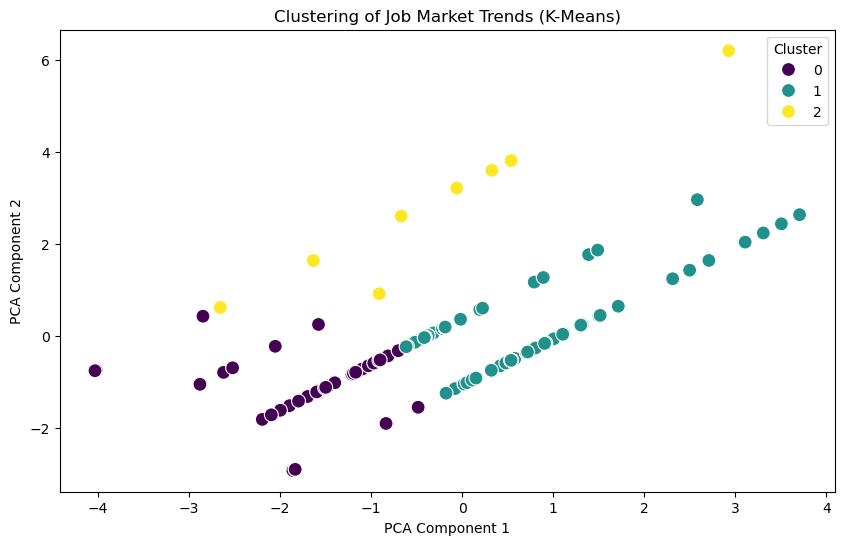

In [90]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Select features for clustering (use average_salary and encode experience_name as an example)
clustering_data = data_cleaned[['average_salary', 'experience_name']]

# Encode 'experience_name' to numerical values
clustering_data['experience_name_encoded'] = clustering_data['experience_name'].astype('category').cat.codes

# Drop the original categorical column after encoding
clustering_data = clustering_data[['average_salary', 'experience_name_encoded']]

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

# Apply PCA to reduce dimensionality for visualization (2 components)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Apply K-Means clustering with an arbitrary number of clusters (e.g., 3)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add cluster labels and PCA results to the original dataset
data_cleaned['cluster'] = clusters
data_cleaned['pca_x'] = pca_data[:, 0]
data_cleaned['pca_y'] = pca_data[:, 1]

# Visualize clusters in PCA space
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca_x', y='pca_y', hue='cluster', data=data_cleaned, palette='viridis', s=100)
plt.title('Clustering of Job Market Trends (K-Means)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


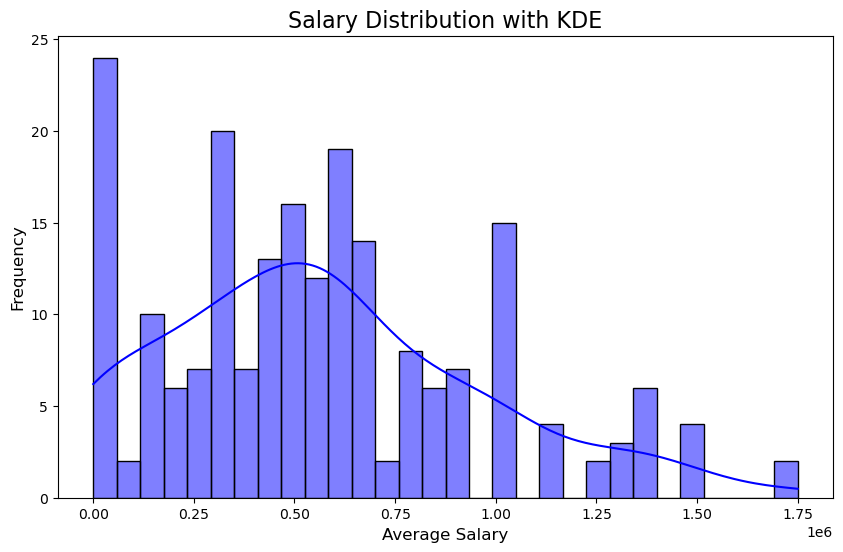

In [172]:
import squarify

# 1. Histogram with KDE for Salary Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['average_salary'], kde=True, color='blue', bins=30)
plt.title('Salary Distribution with KDE', fontsize=16)
plt.xlabel('Average Salary', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()







/var/folders/05/dhrb74p154jf1mg086wnzyqh0000gn/T/ipykernel_54034/4042132370.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='experience_name', y='average_salary', data=df, palette="muted")


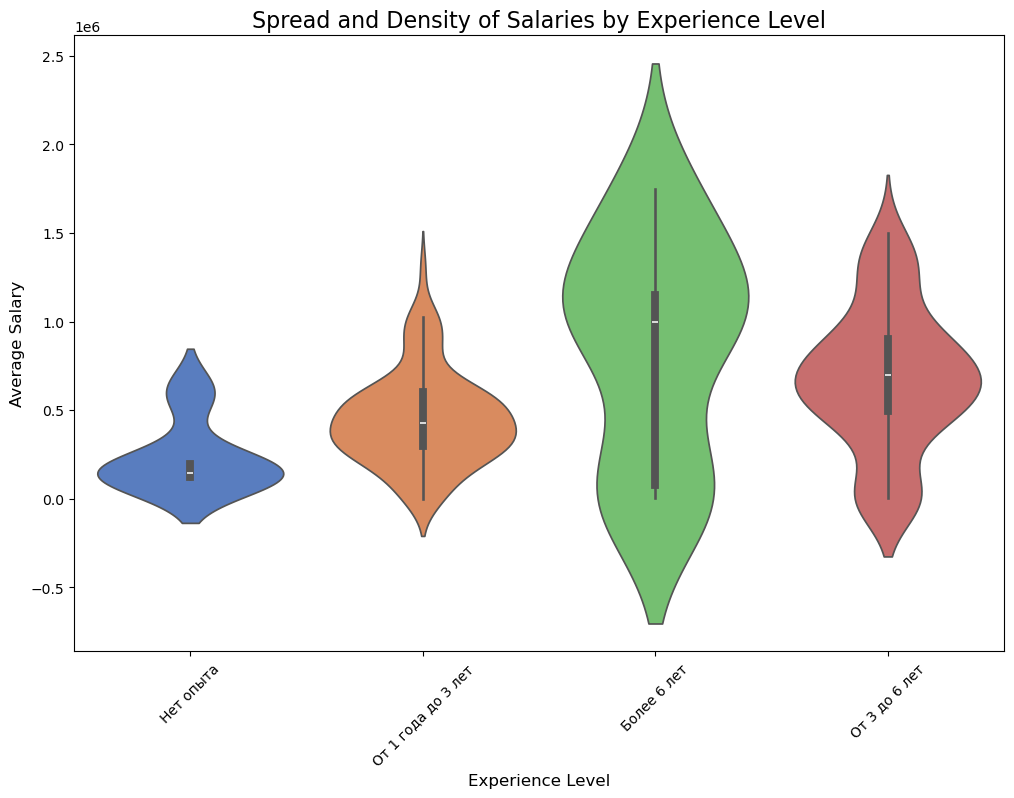

In [230]:
# 3. Violin Plot: Spread and Density of Salaries Across Job Roles
plt.figure(figsize=(12, 8))
sns.violinplot(x='experience_name', y='average_salary', data=df, palette="muted")
plt.title('Spread and Density of Salaries by Experience Level', fontsize=16)
plt.xlabel('Experience Level', fontsize=12)
plt.ylabel('Average Salary', fontsize=12)
plt.xticks(rotation=45)
plt.show()


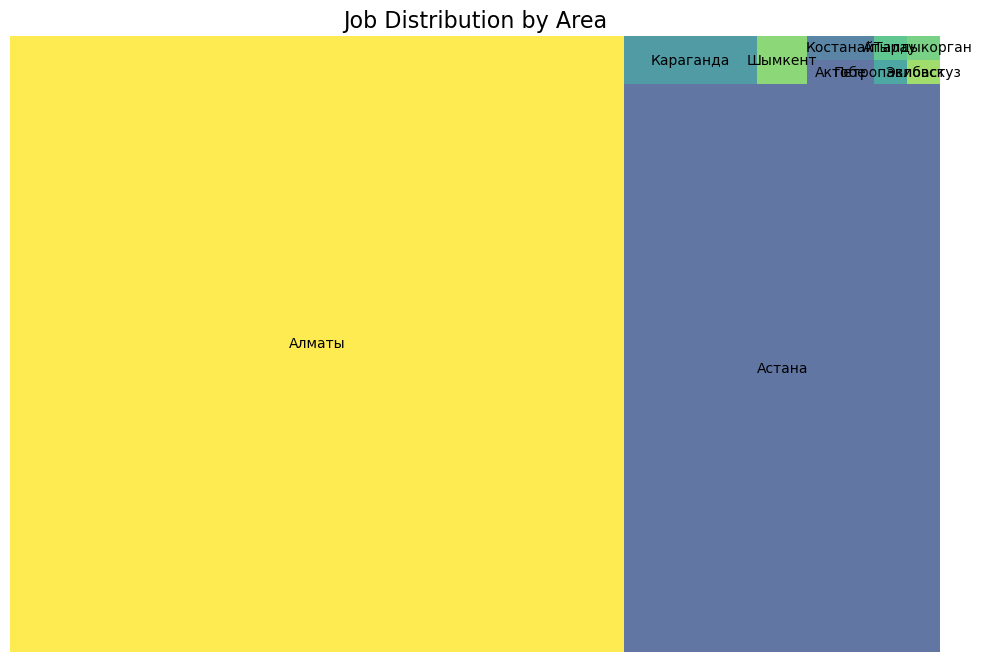

In [167]:

# 5. Treemap: Job Distribution by Area
area_distribution = data_cleaned['area_name'].value_counts()
plt.figure(figsize=(12, 8))
squarify.plot(sizes=area_distribution.values, label=area_distribution.index, alpha=0.8)
plt.title('Job Distribution by Area', fontsize=16)
plt.axis('off')
plt.show()

In [119]:
import re
from datetime import datetime

In [174]:
df['working_hours'] = df['working_hours_id'].str.extract(r'HOURS_(\d+)').astype(float)


In [235]:
df['year_month'] = df['published_at'].dt.to_period('M')



/var/folders/05/dhrb74p154jf1mg086wnzyqh0000gn/T/ipykernel_54034/364858779.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['published_at'].dt.to_period('M')


In [191]:

df

,name,area_name,salary_from,salary_to,salary_currency,published_at,employer_name,requirement,schedule_id,working_hours_id,work_schedule_by_days,professional_roles,experience_name,employment_id,average_salary,working_hours,year_month
0,Junior+ Frontend разработчик,Караганда,NaN,NaN,NaN,2024-12-17 08:23:01+03:00,WOOPPAY,Понимаешь работу и умеешь пользоваться инструм...,fullDay,HOURS_8,5/2,"Программист, разработчик",Нет опыта,full,NaN,8.0,2024-12
1,Senior Frontend Developer,Алматы,NaN,NaN,NaN,2024-12-17 10:46:05+03:00,Grand era,REST. CSS3. Bootstrap / Antd. AJAX.,fullDay,HOURS_8,5/2,"Программист, разработчик",От 1 года до 3 лет,full,NaN,8.0,2024-12
2,Strong Junior Backend разработчик,Алматы,300000.0,400000.0,KZT,2024-12-09 12:25:54+03:00,NCRM GROUP,PostgreSQL. - Понимание принципов архитектуры ...,fullDay,HOURS_4,5/2,"Программист, разработчик",От 1 года до 3 лет,full,350000.0,4.0,2024-12
3,Junior Frontend-разработчик,Алматы,NaN,NaN,NaN,2024-12-10 13:41:08+03:00,oitech,Промышленный опыт <highlighttext>разработки</h...,fullDay,HOURS_8,5/2,"Программист, разработчик",От 1 года до 3 лет,full,NaN,8.0,2024-12
4,Frontend-разработчик,Алматы,150000.0,200000.0,KZT,2024-11-30 09:52:47+03:00,MINDWAVE,"Уверенное владение HTML, CSS(SCSS), JavaScript...",fullDay,HOURS_8,5/2,"Программист, разработчик",От 1 года до 3 лет,full,175000.0,8.0,2024-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,Менеджер по релизам,Алматы,NaN,NaN,NaN,2024-12-15 13:18:21+03:00,Неткрэкер Текнолоджи Казахстан,Опыт работы от 3 лет на должности разработчика...,fullDay,HOURS_8,5/2,Менеджер продукта,От 3 до 6 лет,full,NaN,8.0,2024-12
709,Senior Java Full Stack Engineer,Астана,NaN,NaN,NaN,2024-11-26 15:41:12+03:00,"Epam Kazakhstan (Эпам Казахстан),ТОО",Strong background with Angular 13+. Solid expe...,fullDay,HOURS_8,5/2,"Программист, разработчик",От 3 до 6 лет,full,NaN,8.0,2024-11
710,Senior QA Engineer,Алматы,NaN,NaN,NaN,2024-12-16 11:29:58+03:00,Неткрэкер Текнолоджи Казахстан,Higher Technical education. Minimum 3 year ex...,fullDay,HOURS_8,5/2,Тестировщик,От 3 до 6 лет,full,NaN,8.0,2024-12
711,QA Automation Engineer (Java),Алматы,NaN,NaN,NaN,2024-11-26 17:24:43+03:00,Andersen,Commercial experience as a <highlighttext>QA</...,fullDay,HOURS_8,5/2,Тестировщик,От 3 до 6 лет,full,NaN,8.0,2024-11


In [176]:
df['published_at'] = pd.to_datetime(df['published_at'], errors='coerce')



In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype                    
---  ------                 --------------  -----                    
 0   name                   713 non-null    object                   
 1   area_name              713 non-null    object                   
 2   salary_from            182 non-null    float64                  
 3   salary_to              141 non-null    float64                  
 4   salary_currency        209 non-null    object                   
 5   published_at           713 non-null    datetime64[ns, UTC+03:00]
 6   employer_name          713 non-null    object                   
 7   requirement            712 non-null    object                   
 8   schedule_id            713 non-null    object                   
 9   working_hours_id       713 non-null    object                   
 10  work_schedule_by_days  713 non-null    object     

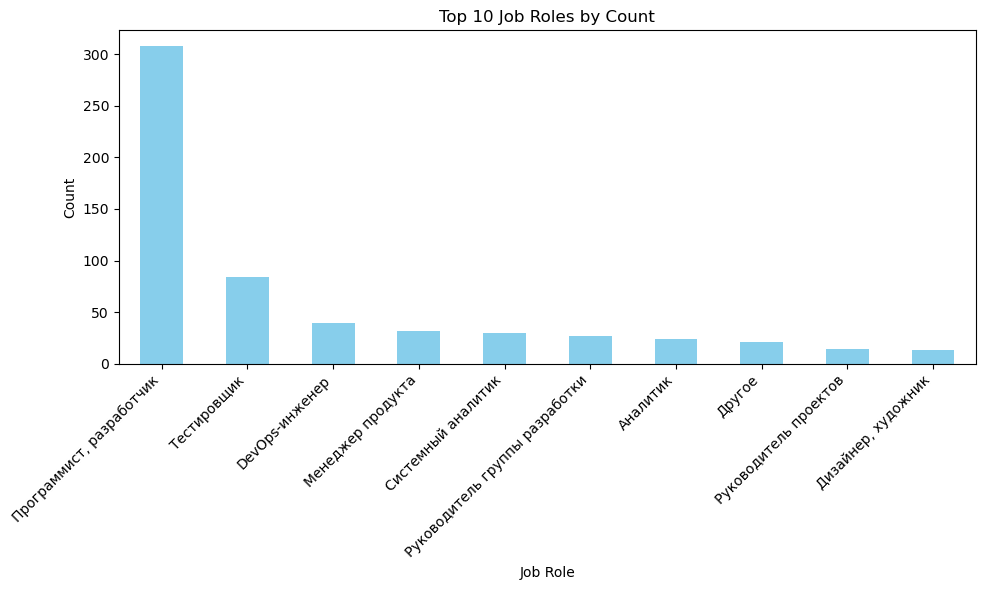

In [195]:
role_distribution = data_cleaned['professional_roles'].value_counts().head(10)

plt.figure(figsize=(10, 6))
role_distribution.plot(kind='bar', color='skyblue')
plt.title("Top 10 Job Roles by Count")
plt.xlabel("Job Role")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

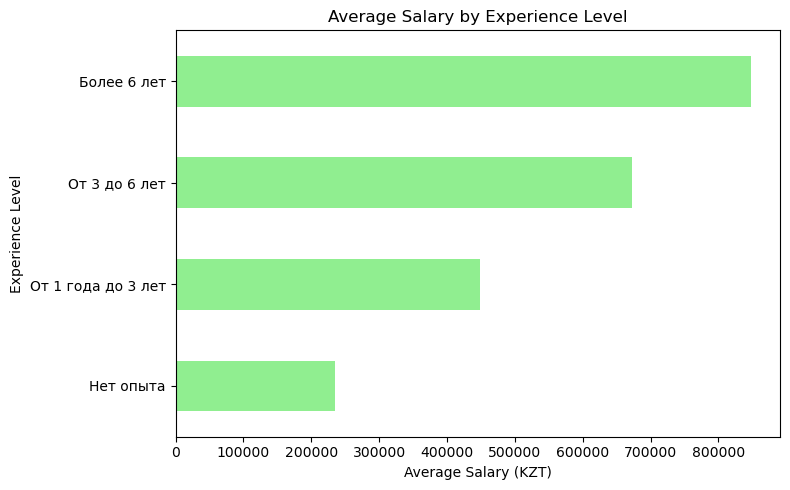

In [237]:
average_salary_experience = df.groupby('experience_name')['average_salary'].mean().sort_values()

plt.figure(figsize=(8, 5))
average_salary_experience.plot(kind='barh', color='lightgreen')
plt.title("Average Salary by Experience Level")
plt.xlabel("Average Salary (KZT)")
plt.ylabel("Experience Level")
plt.tight_layout()
plt.show()

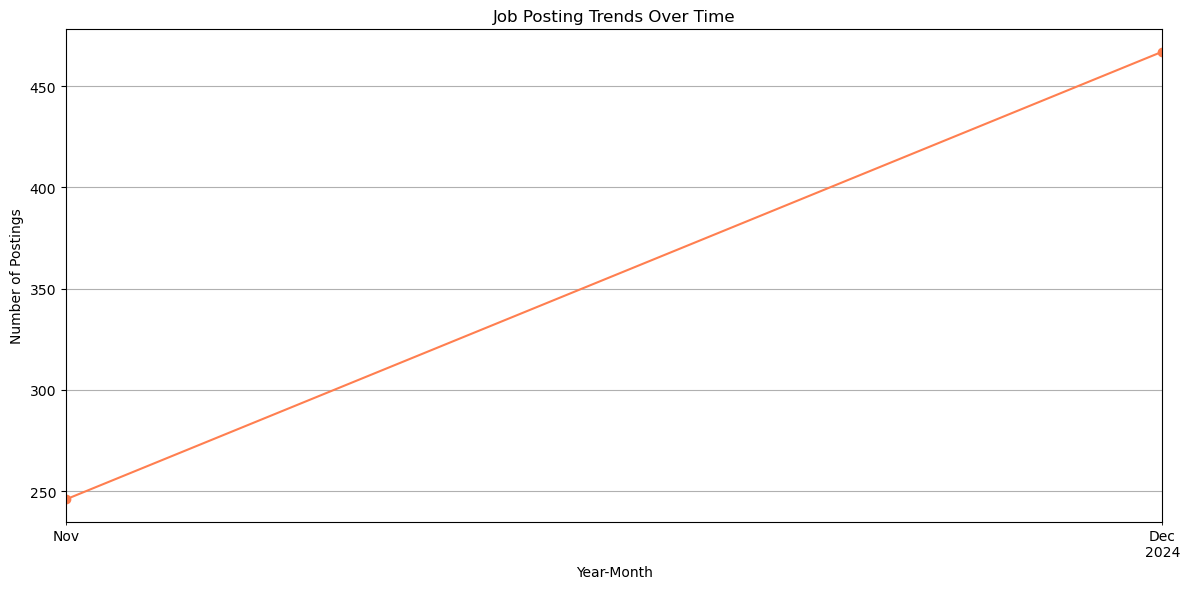

In [208]:
job_posting_trends = df['year_month'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
job_posting_trends.plot(color='coral', marker='o', linestyle='-')
plt.title("Job Posting Trends Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Number of Postings")
plt.grid(True)
plt.tight_layout()
plt.show()

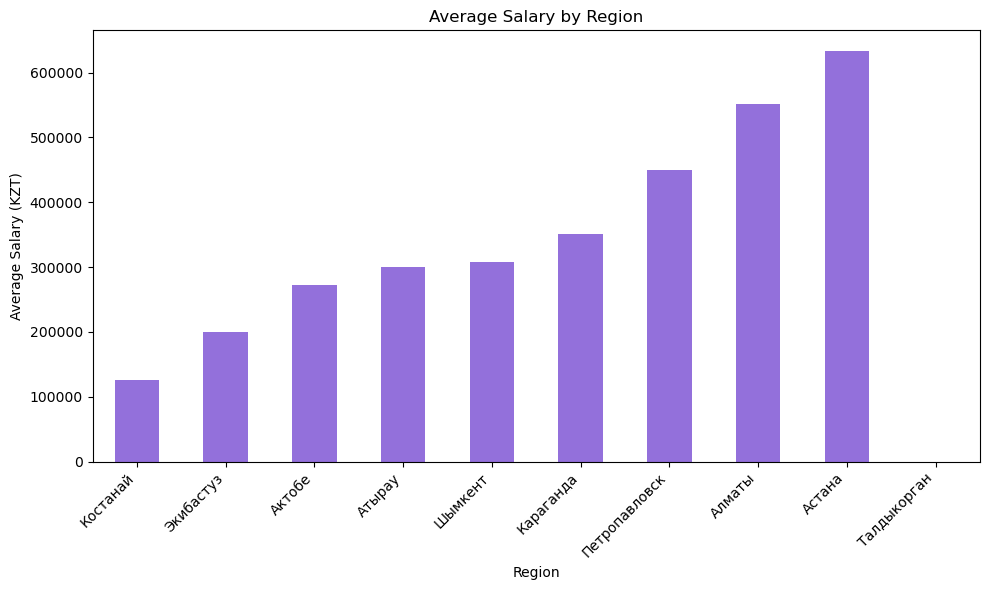

In [216]:
region_salary = df.groupby('area_name')['average_salary'].mean().sort_values()

plt.figure(figsize=(10, 6))
region_salary.plot(kind='bar', color='mediumpurple')
plt.title("Average Salary by Region")
plt.xlabel("Region")
plt.ylabel("Average Salary (KZT)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/var/folders/05/dhrb74p154jf1mg086wnzyqh0000gn/T/ipykernel_54034/1607054344.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='working_hours', y='average_salary', palette="coolwarm")


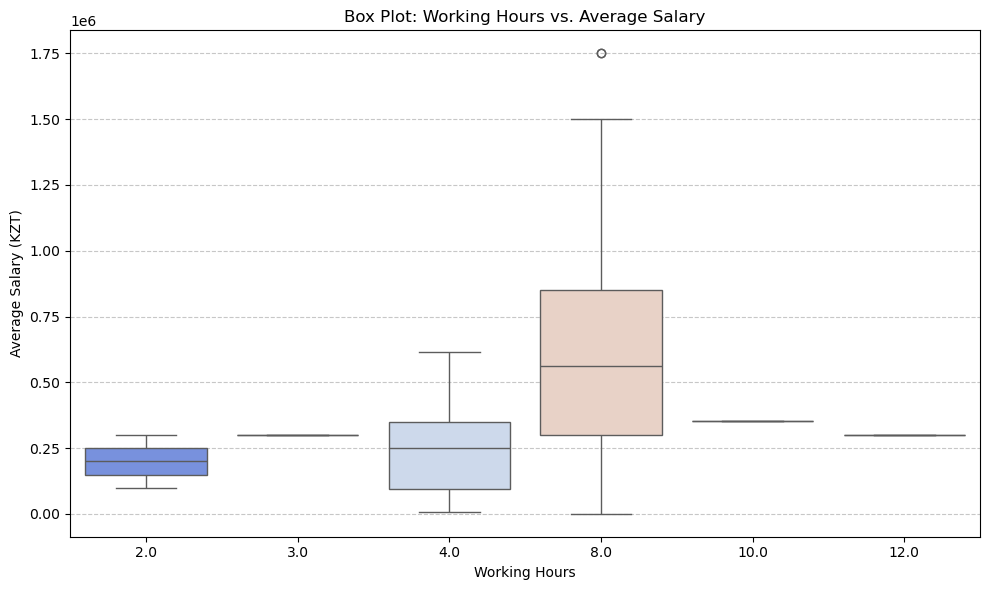

In [226]:
# Box plot of working hours vs. average salary
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='working_hours', y='average_salary', palette="coolwarm")
plt.title("Box Plot: Working Hours vs. Average Salary")
plt.xlabel("Working Hours")
plt.ylabel("Average Salary (KZT)")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
